In [1]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///C:/Users/sebas/sqlite3/lahmansbaseballdb.sqlite')
connection = engine.connect()

from sqlalchemy import MetaData, Table
metadata = MetaData()

people = Table('people', metadata, autoload=True, autoload_with=engine)

batting = Table('batting', metadata, autoload=True, autoload_with=engine)


from sqlalchemy import case, cast, func, select, extract, Date, and_, Boolean, or_

stmt = select ([(people.columns.finalGame).label('activePlayerasof'), people.columns.nameFirst, people.columns.nameLast, 
                people.columns.birthYear, people.columns.birthMonth, people.columns.birthCountry, people.columns.birthState,
                people.columns.birthCity, people.columns.weight,people.columns.height, people.columns.bats, 
                people.columns.throws, batting])

stmt = stmt.where(and_(people.columns.finalGame >= '2019', 
                  case([(batting.columns.stint != 1, batting.columns.G >= 50)], 
                       else_= batting.columns.G >= 50)))

stmt_joined = stmt.select_from(people.join(batting, people.columns.playerID == batting.columns.playerID))
stmt_grouped = stmt_joined.group_by(batting.columns.yearID, batting.columns.playerID, batting.columns.teamID)

##stmt_grouped = stmt_joined.group_by(batting.columns.G)
               
                
results = connection.execute(stmt_grouped).fetchall()
#for record in results:
    #print(record)

In [2]:
import pandas as pd
import datetime 

df = pd.DataFrame(results)

df.columns = results[0].keys()

current_year = datetime.datetime.now().year 
df_DD = datetime.datetime.now().year

df["Age"] = df_DD - df['birthYear']  

df["name"] = df["nameFirst"].map(str) + ' ' + df["nameLast"].map(str) 

df = df.drop(columns=['nameFirst', 'nameLast', 'birthYear', 'birthMonth', 'birthCountry', 'birthState', 
                      'birthMonth','birthCity'])


#df = df.dropna()

#df.isna()

pd.set_option("max_rows", None)

df_re = df.set_index(["name","Age","playerID","activePlayerasof","yearID","stint"]).sort_index()
print(df_re.loc[:, "lgID":"G"])

#print(df_re)

                                                                 lgID    G
name                 Age playerID  activePlayerasof yearID stint          
A. J. Minter         27  minteaj01 2019-09-10       2018   1       NL   65
A. J. Pollock        33  polloaj01 2019-09-29       2013   1       NL  137
                                                    2014   1       NL   75
                                                    2015   1       NL  157
                                                    2017   1       NL  112
                                                    2018   1       NL  113
                                                    2019   1       NL   86
Aaron Altherr        29  altheaa01 2019-08-23       2016   1       NL   57
                                                    2017   1       NL  107
                                                    2018   1       NL  105
Aaron Barrett        32  barreaa01 2019-09-29       2014   1       NL   50
Aaron Bummer         27  

In [3]:
import numpy as np
df_rbi = df.pivot_table("RBI", index="yearID", columns = "name")

df_rbi_lc = df_rbi.loc["2015":"2018"].sum(axis = "index")

#df_rbi_lc = df_rbi_lc.replace(0, np.nan) 

#df_rbi_lc = df_rbi_lc.dropna(how='all', axis=0)


## Active player who had most runs batted in (RBI) from 2015-2018
print(df_rbi_lc.idxmax())
print(df_rbi_lc.max())

Nolan Arenado
503.0


In [4]:
df_gidp = df.pivot_table("GIDP", index="yearID", columns = "name")

df_gidp_lc = df_gidp.loc["2016": "2017" ]

print(df_gidp_lc['Albert Pujols'])

##Albert Pujols had palyed 24 double plays gorund into GIDP in 2016

yearID
2016    24.0
2017    26.0
Name: Albert Pujols, dtype: float64


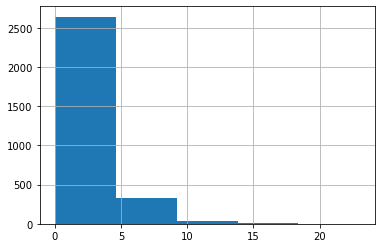

In [5]:
import matplotlib.pyplot as plt
#Histogram of triples (3B) per year

df["3B"].hist(bins=5)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

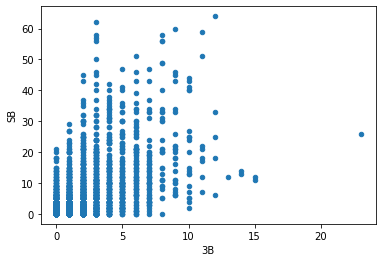

In [6]:
#Scatter Plot Relating triples (3B) and steals (SB)
df.plot(x="3B", y="SB",kind="scatter")
plt.show

In [7]:
## Additional Question # 1 - Number of Active Players who used to be both hands batting (Count "B" in the column 'bats')

df_count = df.groupby('bats').size()
print(df_count)
# There are 318 both hands batting players

bats
B     323
L     945
R    1738
dtype: int64


In [8]:
## Additional Question # 2 - The active player who had most doubles (2B) from 2015-2019
df_2b = df.pivot_table("2B", index="yearID", columns = "name")

df_2b_lc = df_2b.loc["2015":"2019"].sum(axis = "index")

#df_2b_lc = df_2b_lc.replace(0, np.nan) 

#df_2b_lc = df_2b_lc.dropna(how='all', axis=0)


## Active player who had most doubles (2B) from 2015-2019
print(df_2b_lc.idxmax())
print(df_2b_lc.max())

Mookie Betts
217.0


<function matplotlib.pyplot.show(*args, **kw)>

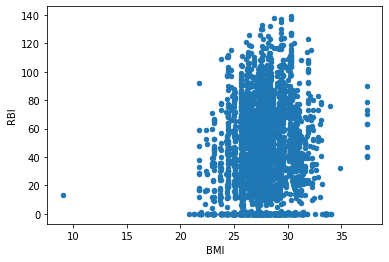

In [9]:
## Additional Question # 3 - Scatter plot on Body Mass Index (BMI) active players and RBI
## BMI = weight (lb) / [height (in)]2 x 703
df["BMI"] = (df["weight"] / df["height"]**2) * 703
#Scatter on Body Mass Index (BMI) and RBI
df.plot(x="BMI", y="RBI",kind="scatter")
plt.show

In [10]:
#### Additional Question # 4 
df_age = df.set_index(["name"]).sort_index()

df_age_lc = df_age.loc[:, "Age"]
print(df_age_lc.max())
print(df_age_lc.idxmax())
# Among The Active Players who is at the highest age?

47
Ichiro Suzuki


In [11]:
#### Additional Question # 5 
df_count = df.groupby('stint').size()
print(df_count)

stint
1    2951
2      53
3       2
dtype: int64


In [12]:
#### Additional Question # 6 
print(df['playerID'].nunique())
## No of Active players as of 2019

748


In [13]:
#### Additional Question # 7
print(df['name'].nunique())
## 2 Players have the same Name Will Smith with 2 different player IDs - smithwi04 and smithwi05

747
